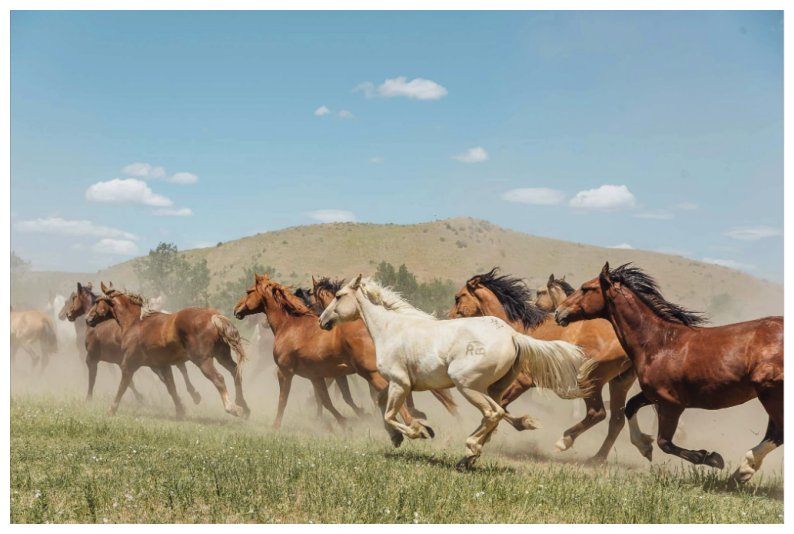

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
image = cv2.imread('horses.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

cpu


In [3]:
masks = mask_generator.generate(image)
print(masks[0].keys())

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


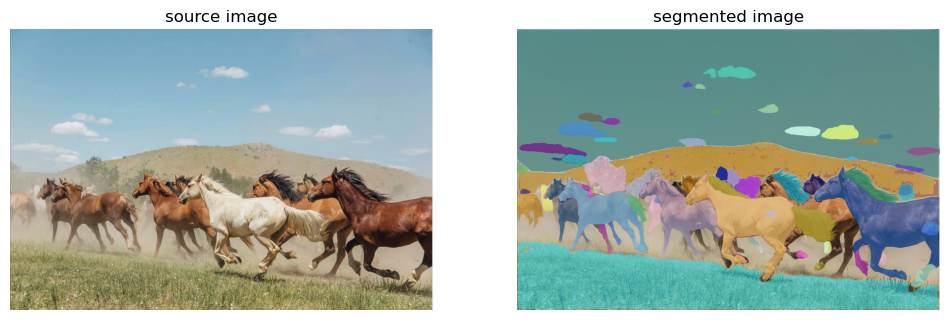

In [4]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

sv.plot_images_grid(
    images=[image_rgb, annotated_image_rgb],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [5]:
import os
import glob

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
style_image_file = './styles/style-1.jpg'

org_image = cv2.imread('horses.png')

### sort masks according to area descendingly
sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

segmented_masks = [
    mask['segmentation']
    for mask in sorted_masks
]

mask = (segmented_masks[4] * 255).astype(np.uint8) 

#sorted_segmented_masks=[]
#
#for i in range(1,7):
#    mask = (segmented_masks[i] * 255).astype(np.uint8) 
#    sorted_segmented_masks.append(mask)
#
#sv.plot_images_grid(
#    images=sorted_segmented_masks,
#    grid_size=(2, 7),
#    titles=['area sorted masks'])


# 1. Style and Mask

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(-0.5, 1007.5, 668.5, -0.5)

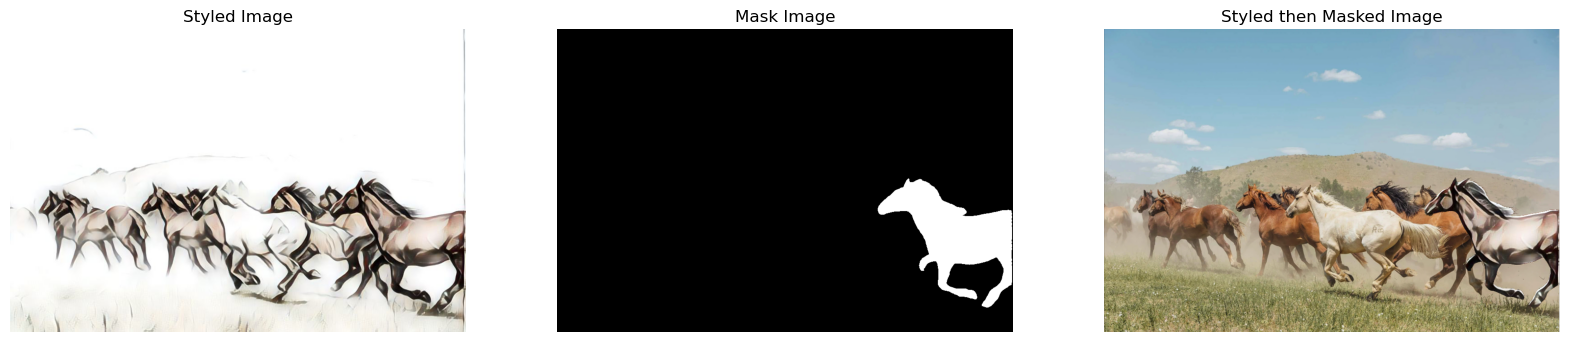

In [6]:
styled_image_file = './output/styled-0.png'
org_styled_image_file = './output/org-style-4.jpg'

### style the original image
os.system('python ' + linear_style_transfer_file + ' ' + 'horses.png' + ' ' + style_image_file + ' ' + org_styled_image_file)

### resize styled image to original size    
org_styled_image = cv2.imread(org_styled_image_file)
target_height, target_width = org_image.shape[:2]
org_styled_image = cv2.resize(org_styled_image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)

### regenerating styled-masked image
inverse_mask = cv2.bitwise_not(mask)
masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
styled_masked = cv2.bitwise_and(org_styled_image, org_styled_image, mask=mask)
final_styled_masked_image = cv2.add(masked_original, styled_masked)    

### plot the images
mask_image_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
org_styled_image_rgb = cv2.cvtColor(org_styled_image, cv2.COLOR_BGR2RGB)
final_styled_masked_image_rgb = cv2.cvtColor(final_styled_masked_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(org_styled_image_rgb)
plt.title('Styled Image')
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(mask_image_rgb)
plt.title('Mask Image')
plt.axis('off')  

plt.subplot(1, 3, 3)
plt.imshow(final_styled_masked_image_rgb)
plt.title('Styled then Masked Image')
plt.axis('off')


# 2. Mask and Style

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(-0.5, 1007.5, 668.5, -0.5)

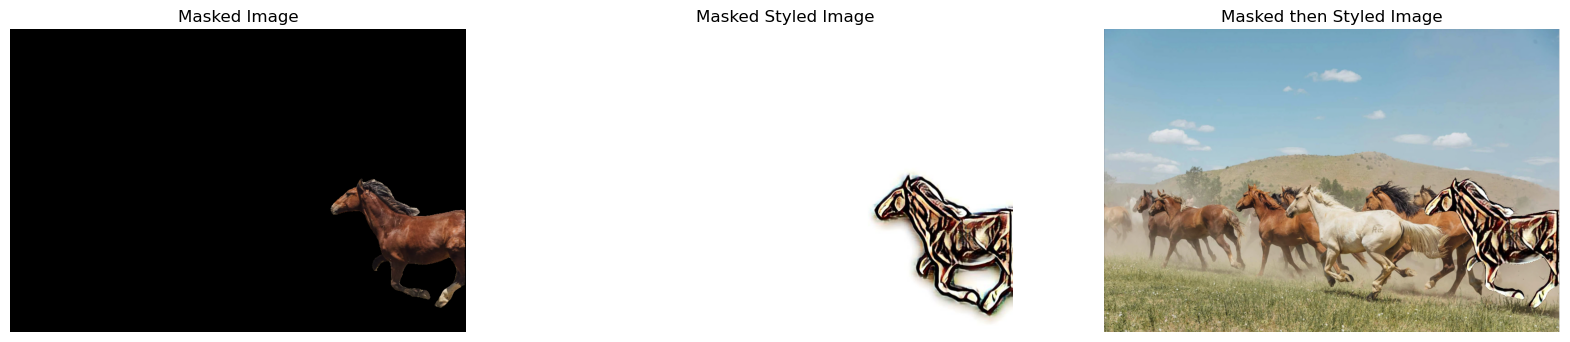

In [7]:
masked_image_file = './output/masked-4.jpg'
masked_styled_image_file = './output/masked-style-4.jpg'

### mask the original image
mask = (segmented_masks[4] * 255).astype(np.uint8) 
masked_image = cv2.bitwise_and(org_image, org_image, mask=mask)

### style the masked image
cv2.imwrite(masked_image_file, masked_image)
os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + style_image_file + ' ' + masked_styled_image_file)

### resize styled image to original size    
masked_styled_image = cv2.imread(masked_styled_image_file)
target_height, target_width = org_image.shape[:2]
masked_styled_image = cv2.resize(masked_styled_image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)

### regenerating masked-style image
inverse_mask = cv2.bitwise_not(mask)
masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
masked_styled = cv2.bitwise_and(masked_styled_image, masked_styled_image, mask=mask)
final_masked_styled_image = cv2.add(masked_original, masked_styled)    

### plot the images
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
masked_styled_image_rgb = cv2.cvtColor(masked_styled_image, cv2.COLOR_BGR2RGB)
final_masked_styled_image_rgb = cv2.cvtColor(final_masked_styled_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1) 
plt.imshow(masked_image_rgb)
plt.title('Masked Image')
plt.axis('off')  

plt.subplot(1, 3, 2)
plt.imshow(masked_styled_image_rgb)
plt.title('Masked Styled Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_masked_styled_image_rgb)
plt.title('Masked then Styled Image')
plt.axis('off')

# 3. Bounding-Box Styled

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(-0.5, 1007.5, 668.5, -0.5)

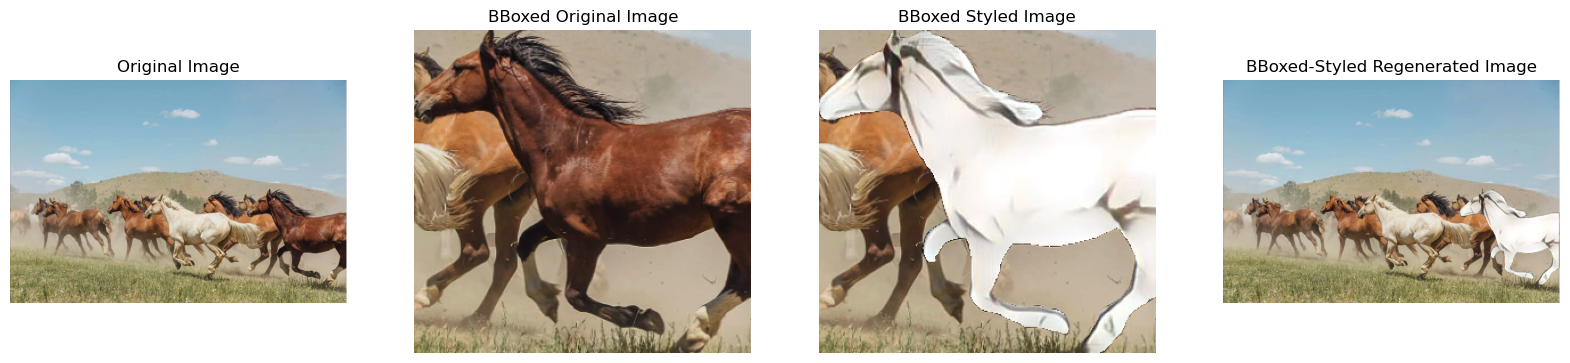

In [8]:
bboxed_image_file = './output/bboxed-masked-4.jpg'
bboxed_styled_image_file = './output/bboxed-masked-style-4.jpg'

org_image = cv2.imread('horses.png')
mask = (sorted_masks[4]['segmentation'] * 255).astype(np.uint8) 

bbox = sorted_masks[4]['bbox']

### bbox and mask the original image
x, y, w, h = bbox
bboxed_mask = mask[y:y+h, x:x+w]
original_bboxed_image = org_image[y:y+h, x:x+w]
masked_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=bboxed_mask)

### style the bboxed image
cv2.imwrite(bboxed_image_file, masked_bboxed_image)
os.system('python ' + linear_style_transfer_file + ' ' + bboxed_image_file + ' ' + style_image_file + ' ' + bboxed_styled_image_file)

bboxed_styled_image = cv2.imread(bboxed_styled_image_file)
bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
masked_styled_bboxed_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)

### regenerating bboxed styles original image
inverse_mask = cv2.bitwise_not(bboxed_mask)
masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)

final_bboxed_masked_styled_image = cv2.add(masked_styled_bboxed_image, masked_original_bboxed_image) 

bbox_masked_styled_image = cv2.imread('horses.png')
bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 

### plot the images
mask_image_rgb = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
original_bboxed_image_rgb = cv2.cvtColor(original_bboxed_image, cv2.COLOR_BGR2RGB)
bboxed_styled_image_rgb = cv2.cvtColor(final_bboxed_masked_styled_image, cv2.COLOR_BGR2RGB)
bbox_masked_styled_image_rgb = cv2.cvtColor(bbox_masked_styled_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 20))

plt.subplot(1, 4, 1)
plt.imshow(mask_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2) 
plt.imshow(original_bboxed_image_rgb)
plt.title('BBoxed Original Image')
plt.axis('off')  

plt.subplot(1, 4, 3) 
plt.imshow(bboxed_styled_image_rgb)
plt.title('BBoxed Styled Image')
plt.axis('off')  

plt.subplot(1, 4, 4) 
plt.imshow(bbox_masked_styled_image_rgb)
plt.title('BBoxed-Styled Regenerated Image')
plt.axis('off')  


# 4. Plot the Styled-Masked, Masked-Styled and BBoxed-Masked-Styled Images

(-0.5, 1007.5, 668.5, -0.5)

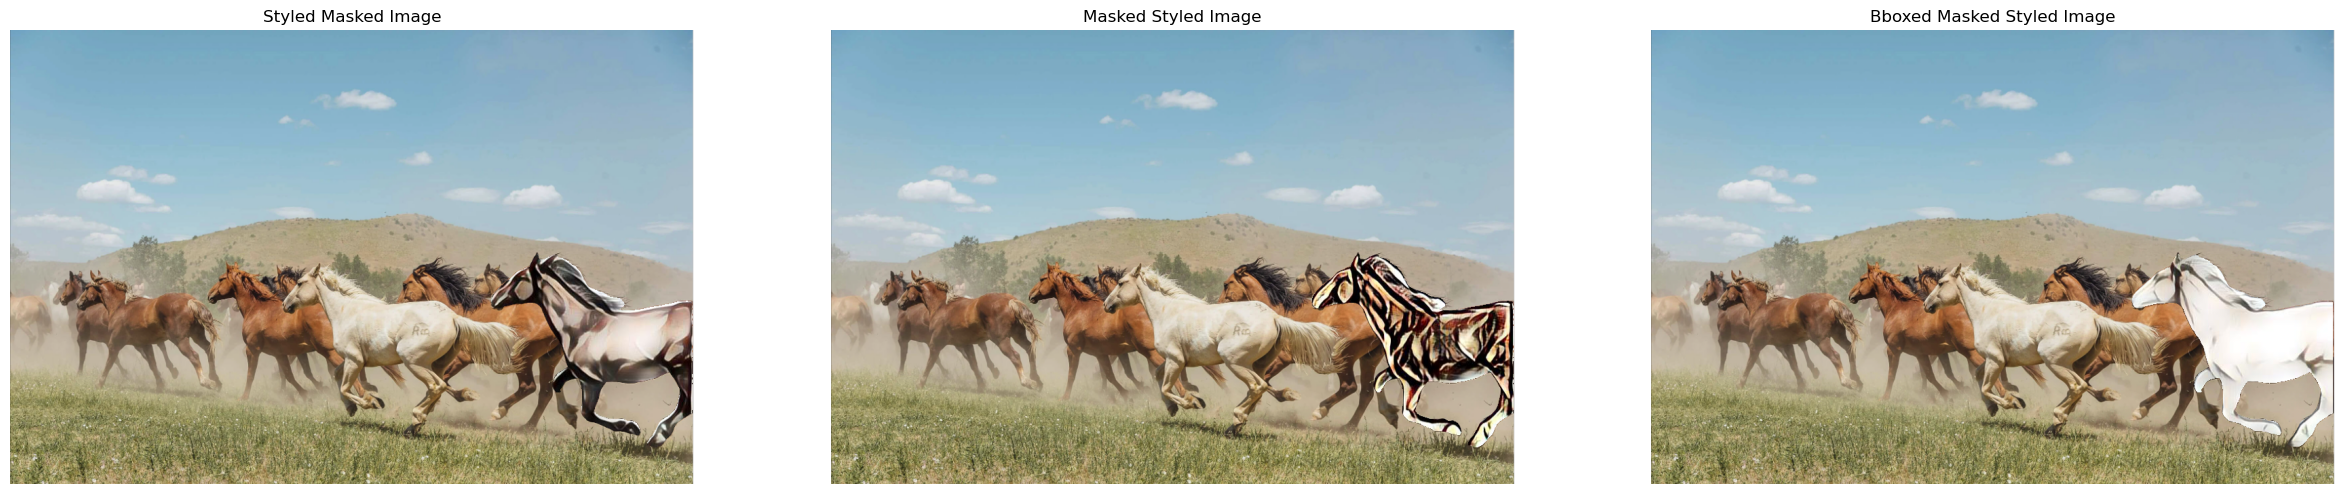

In [9]:
plt.figure(figsize=(30, 30))

plt.subplot(1, 3, 1) 
plt.imshow(final_styled_masked_image_rgb)
plt.title('Styled Masked Image')
plt.axis('off')  

plt.subplot(1, 3, 2)
plt.imshow(final_masked_styled_image_rgb)
plt.title('Masked Styled Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bbox_masked_styled_image_rgb)
plt.title('Bboxed Masked Styled Image')
plt.axis('off')

In [ ]:
### TODO:

### masking - styling - regenerate the original image
### masking with bounding box - styling - regenerate the original image
### styling - masking - regenerate the original image

### create the pipeline

### partial convolution